# Leitura de dados binários comprimidos - um exemplo de otimização gradual em Python
> As atividades de monitoramento do espectro de radiofrequência na ANATEL, especificamente aquelas que utilizam estações remotas de monitoramento, geram centenas de GB de dados. Um dos primeiros desafios para a utilização mais eficiente desses dados é a sua leitura eficiente. Nesse artigo é detalhada as iterações realizadas para resolver esse problema, primeiramente tornar essa leitura viável e posteriormente os passos de otimização aplicados no algoritmo para decodificar os dados de arquivos comprimidos 

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [spectrum monitoring, profiling, numpy, cython]
- image: images/copied_fom_nb/images/devil.png
- hide_binder_badge: true
- author: Ronaldo S.A. Batista

![](images/knuth.png "Crédito da Imagem: https://twitter.com/lpolovets/status/816117631572807680")

O objeto desse artigo são arquivos binários com extensão `.bin` - gerados pela aplicação `Logger` embarcada nas estações de monitoramento do tipo [Rfeye Node 20-6](http://agc.com.br/produto/rfeye-node/).

Estes arquivos armazenam diversos metadados sobre a medição e blocos com informação numérica, que são as medidas em si, chamadas aqui de _dados de espectro_ ou _dados espectrais_ ou _dados de nível_. 

A versão recente da aplicação `Logger` gera dados comprimidos de maneira muito eficiente, o que torna a descompressão desafiadora para arquivos com muitos dados e bastante demorada caso seja feita de maneira "ingênua".

Mesmo que o problema apresentado aqui pareça obscuro, as técnicas de otimização podem ser aplicadas em outros contextos que sejam relevantes para quem lê.

> Note: Nos parágrafos a seguir irei passar por cima deliberadamente ( por não serem relevantes para a otimização e por pouco conhecimento no assunto ) de explicações sobre a parte de física / engenharia de telecomunicações e irei focar mais no problema específico de decodificação dos arquivos.

## Bibliotecas necessárias

In [ ]:
!pip3 install rfpye line_profiler fastprogress -qUU

## Baixando arquivos binários
Como primeiro passos precisamos de alguns tipos de arquivos binários como exemplo: Neste repositório é disponibilizado diversos tipos de Arquivos de Espectro: https://github.com/EricMagalhaesDelgado/SpecFiles

Para nossos propósitos queremos um arquivo comprimido, cujo nome contém `MaskBroken`

In [ ]:
!wget 'https://drive.google.com/u/2/uc?id=1K-riwTKeP6HuUtnRFuN2wxjRrdRxApdu&export=download' --output-document 'rfeye002092_210223_T163131_MaskBroken.bin'

--2021-09-20 03:16:45--  https://drive.google.com/u/2/uc?id=1K-riwTKeP6HuUtnRFuN2wxjRrdRxApdu&export=download
Resolving drive.google.com (drive.google.com)... 64.233.189.101, 64.233.189.139, 64.233.189.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a228g2dpkhdrm9ipevs8oojmqa58dplb/1632107775000/01599860855598048438/*/1K-riwTKeP6HuUtnRFuN2wxjRrdRxApdu?e=download [following]
--2021-09-20 03:16:47--  https://doc-0g-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a228g2dpkhdrm9ipevs8oojmqa58dplb/1632107775000/01599860855598048438/*/1K-riwTKeP6HuUtnRFuN2wxjRrdRxApdu?e=download
Resolving doc-0g-00-docs.googleusercontent.com (doc-0g-00-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connecting to doc-0g-00-docs.googleusercontent.com (doc

## Explorando o arquivo `.bin`

Cada arquivo `.bin` possui dados distintos em um mesmo arquivo, em dois níveis `blocos` e `thread_id`.

* Um `bloco` determina o tipo de dado: espectro, gps, dados textuais etc...
* O `thread_id` nada mais é que um identificador da faixa específica de varredura armazenada naquele bloco.

A função a seguir `parse_bin` encapsula a leitura do arquivo e seus metadados e retorna um dicionário cujas chaves são as diferentes combinações de `blocos` e `thread_id` e os valores são listas com os blocos. 

> Note: Cada bloco é uma classe python contendo seus atributos. Os detalhes de implementação dessa função podem ser ignorados, o que nos interessa aqui é uma vez que temos os bytes de dados com os valores de níveis como o lemos de maneira eficiente para ponto flutuante.

> Tip: A biblioteca `rfpye` criada para o processamento desses arquivos faz amplo uso da biblioteca [fastcore](https://fastcore.fast.ai/). Esta expande as funcionalidades da linguagem python inspirada em atributos muito úteis de outras linguagens. Recomendo fortemente para quem deseja expandir o seu inventário de ferramentas python

In [ ]:
#hide
%load_ext line_profiler

In [ ]:
import os
from tqdm.notebook import tqdm
from time import sleep
from fastcore.xtras import Path
import gc
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
from rfpye.parser import parse_bin
from rfpye.utils import public_attrs
from fastcore.foundation import L
import numpy as np
import pandas as pd
from rich import print
from IPython.display import display

In [ ]:
blocks = parse_bin('rfeye002092_210223_T163131_MaskBroken.bin')

blocks = blocks['blocks']

for k,v in blocks.items():
    print(f'Tipo de Bloco: {k[0]}, Thread_ID: {k[1]}, Nº de blocos {len(v)}, Exemplo de Blocos: {v[0]}')

Tipo de Bloco: 21, Thread_ID: 0, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType21 
object at 0x7f1f7f285390>

Tipo de Bloco: 42, Thread_ID: 0, Nº de blocos 2, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7fb72210>

Tipo de Bloco: 42, Thread_ID: 301, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838e4d0>

Tipo de Bloco: 42, Thread_ID: 311, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838e550>

Tipo de Bloco: 42, Thread_ID: 321, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838e610>

Tipo de Bloco: 42, Thread_ID: 331, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838e6d0>

Tipo de Bloco: 68, Thread_ID: 331, Nº de blocos 734, Exemplo de Blocos: <rfpye.blocks.DType68
object at 0x7f1f7838e790>

Tipo de Bloco: 42, Thread_ID: 341, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838ea90>

Tipo de Bloco: 42, Thread_ID: 351, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838eb50>

Tipo de Bloco: 42, Thread_ID: 361, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838ec10>

Tipo de Bloco: 42, Thread_ID: 371, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838ecd0>

Tipo de Bloco: 42, Thread_ID: 381, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838ed90>

Tipo de Bloco: 42, Thread_ID: 391, Nº de blocos 1, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f7838ee50>

Tipo de Bloco: 68, Thread_ID: 301, Nº de blocos 133932, Exemplo de Blocos: 
<rfpye.blocks.DType68 object at 0x7f1f7838ef10>

Tipo de Bloco: 68, Thread_ID: 311, Nº de blocos 11464, Exemplo de Blocos: 
<rfpye.blocks.DType68 object at 0x7f1f77c1e890>

Tipo de Bloco: 40, Thread_ID: 1, Nº de blocos 18462, Exemplo de Blocos: <rfpye.blocks.DType40
object at 0x7f1f77c20210>

Tipo de Bloco: 42, Thread_ID: 1, Nº de blocos 307, Exemplo de Blocos: <rfpye.blocks.DType42 
object at 0x7f1f77b1b390>

Tipo de Bloco: 68, Thread_ID: 341, Nº de blocos 44, Exemplo de Blocos: <rfpye.blocks.DType68 
object at 0x7f1f7704ffd0>

Tipo de Bloco: 68, Thread_ID: 321, Nº de blocos 46, Exemplo de Blocos: <rfpye.blocks.DType68 
object at 0x7f1f73715110>

Vemos que esse arquivo tem diferentes tipos de blocos, um bloco nada mais é que uma classe python que armazenada os atributos do bloco.

O que nos interessa aqui são os blocos de espectro, blocos do tipo 68.

Temos 5 diferentes blocos do tipo 68, vamos observar o que os diferencia:

In [ ]:
b301 = blocks[(68,301)][0]
b321 = blocks[(68,321)][0]
b331 = blocks[(68,331)][0]
b341 = blocks[(68,341)][0]

In [ ]:
print(f'Frequência Inicial (MHz) :{b301.start_mega}, Frequência Final (MHz) {b301.stop_mega}')

Frequência Inicial (MHz) :108, Frequência Final (MHz) 137

In [ ]:
print(f'Frequência Inicial (MHz) :{b321.start_mega}, Frequência Final (MHz) {b321.stop_mega}')

Frequência Inicial (MHz) :320, Frequência Final (MHz) 340

In [ ]:
print(f'Frequência Inicial (MHz) :{b331.start_mega}, Frequência Final (MHz) {b331.stop_mega}')

Frequência Inicial (MHz) :400, Frequência Final (MHz) 410

In [ ]:
print(f'Frequência Inicial (MHz) :{b341.start_mega}, Frequência Final (MHz) {b341.stop_mega}')

Frequência Inicial (MHz) :960, Frequência Final (MHz) 1219

Vemos portanto que o quê diferencia diferentes blocos do mesmo tipo mas com diferentes `thread_id` é a faixa de frequência de varredura. 

O primeiro tipo de bloco mostrado, o bloco do tipo `68` e thread_id `301`, é o mais numeroso do arquivo com 133932 blocos. 

A faixa desse arquivo é muito importante e de grande enfoque nas monitorações da Anatel - 108MHz a 137MHz. Essa faixa é a do Serviço Limitado Móvel Aeronáutico, dedicada a comunicações entre aeronaves com as torres de comando e entre si.

Cada bloco é uma medição num intervalo de tempo específico dessa faixa, no caso 108MHz a 137MHz, dividida em várias amostras ( recortes ) da faixa. Portanto temos `133932` medições.

In [ ]:
print(b301.data[b301.start:b301.stop])

b'\xff\xfaF\xff\xfaH\xff\xfaH\xff\xfaE\xff\xfaA\xff\xfaB\xff\xfaA\xff\xfa>\xff\xfa>\xff\xfa=\
xff\xfa<\xff\xfa;\xff\xfa;\xff\xfa;\xff\xfa;\xff\xfa;\xff\xfa5\xff\xfa5\xff\xfa6\xff\xfa7\xff
\xfa8\xff\xfa7\xff\xfa6\xff\xfa4\xffv`d`\xff\xfa6\xff\x9bamm`\xff\xfa6\xff\xfa8\xff\xfa8\xff\
xfa8\xff\xfa8\xff\xfa7\xff\xfa6\xff\xfa5\xff\x8ba\xff\xfa4\xff\xfa6\xff\xfa4\xff\xfa5\xff\xfa
5\xff\x97g|\x82{f\xff\xfa5\xff\xfa5\xff\xfa7\xff\xfa7\xff\xfa8\xff\xfa6\xff\xfa6\xff\xfa6\xff
\xfa8\xff\xfa7\xff\xfa8\xff\xfa8\xff\xfa9\xff\xfa<\xff\xfa>\xff\xfa>\xff\xfaA\xff\xfaAB\x00\x
00'

O Atributo `data` são os bytes brutos, i.e. não decodificados. Os atributos `start` e `stop` recortam os bytes nos pontos correspondentes às medidas de nível do arquivo binário, os demais pontos do arquivo, os metadados, são decodificados como atributos da classe, um exemplo foi mostrado acima com os atributos `start_mega` e `stop_mega`.

O restante desse artigo é dedicado a decodificação dessas medidas de nível.

## Codificação Espectral
Dada estação faz uma medição de potência, para dada frequência, em dBm ( lê-se 'de-bê-eme' ), uma escala logarítmica com valores tipicamente negativos. A escala de valores que a estação armazena é a seguinte `Intervalo = [offset - 127.5, offset]`, onde `offset` (*deslocamento*) é um valor pré-estabelecido. Se a medida estiver fora desse intervalo, os valores são truncados. Um típico valor de `offset` é -*20dBm*

Assim tendo o valor medido `d` em dBm ele é codificado e salvo no arquivo como um valor `b`:

$$b = 2(d - offset) + 255$$

Ao inserir os valores extremos do intervalo acima nessa fórmula:

Para `d = offset - 127.5`:

$$ \therefore b = 2[(offset - 127.5) - offset] + 255 = 2 (-127.5) + 255 \implies b = 0$$

Para `d = offset`:
$$\therefore b = 2(offset - offset) + 255 = 2 * 0 + 255 \implies b = 255$$

Portanto o intervalo de valores possíveis ao serem codificados com a fórmula acima é `[0,255]`, justamente o intervalo de valores possíveis em 8 bits ou 1 byte, sem sinal. Assim, os dados de espectro truncados e codificados dessa maneira permitem um armazenamento extremamente econômico, ocupando somente 1 byte (`uint8` em python ou `unsigned char` na linguagem C.)

Para decodificar tal valor, basta fazer o procedimento inverso  da fórmula acima. Ao isolar o valor `d` temos:
$$d = \frac{b}{2} + offset - 127.5$$

## Compressão de Dados
Como dados de espectro são extremamente ruidosos ( índice sinal-ruído muito baixo ), isto é, a maioria do que observamos numa dada "janela" do espectro é simplesmente ruído, a aplicação `Logger` comprime esses dados de maneira engenhosa. Como mencionado, a cada instante de tempo a estação faz a medição dos níveis de determinada faixa, para tal ela divide a faixa em diversos intervalos e mede o nível da frequência central daquele intervalo. Quanto maior o número de intervalos mais granulosa ou detalhada serão essas medidas.

**Algoritmo de Compressão**

* No script é definido um limiar `threshold`, abaixo do qual tudo é considerado ruído
* Para cada intervalo medido `i`, é verificado se o valor está abaixo do limiar
* Caso afirmativo esse processo se repete para os intervalos vizinhos `i+1, i+2, etc...`
* Esses intervalos são contados, até que apareça um ponto acima do limiar ou o máximo de `250` pontos seja atingido
  * Nesse ponto é gravado no arquivo um byte marcador `RUN=255` indicando que o próximo byte armazena a contagem de pontos abaixo do limiar
  * Nesse procedimento é ocupado somente 2 bytes, podendo ter sido comprimido o limite de 250 bytes no melhor dos casos.

Um problema que pode ocorrer no algoritmo acima é se nos dados de medição tivermos o valor máximo medido `d=offset` assim o valor a ser gravado será `b=255`, o mesmo valor usado como marcador. 

Nesses casos temos o valor literal no ponto e não queremos que isso seja interpretado como marcador. 

Para lidar com esse caso é definido um segundo marcador `ESC=254`, esse marcador informa o algoritmo de decodificação que a medida seguinte é literal e não se trata de um marcador. Esse marcador também é utilizado para realizar escape dele mesmo, isto é, quando a medida codificada é exatamente igual a `b=254`, isso ocorre quando o valor medido é: `d=offset - 0.5`. Para verificar basta substituir esse valor na fórmula acima.

Com alguns exemplos a seguir ficará mais claro o funcionamento do algoritmo. O algoritmo original de codificação ( escrito em C ) é apresentado a seguir:

```c
int run_length_encode(unsigned char *dest, unsigned char *src, int nsrc, int thresh) { 
    unsigned char ib; 
    int di = 0, si, nunder = 0; 
    for(si = 0; si < nsrc; si++){ 
        ib = src[si]; 
        if ((ib < thresh) && (si < (nsrc-1)) && (nunder < 250)) { 
            nunder += 1; 
        } else { 
            if (nunder > 0) { 
                dest[di++] = RUN; 
                dest[di++] = nunder; 
                nunder = 0; 
            } if ((ib == RUN) || (ib == ESC)) {
                dest[di++] = ESC; 
                dest[di++] = ib; 
            } else { 
                dest[di++] = ib; 
            } 
        } 
    } return di; 
}
```

O algoritmo é bastante legível mesmo para quem não conhece C, exceto talvez por algumas coisas estranhas como ponteiros `*` e a incrementação de variáveis dentro dos arrays. 
Vamos escrevê-lo em python sem alterar sua estrutura em C mas colocando nomes das variáveis mais amigáveis e comentando para decifrarmos melhor seu propósito. 

In [ ]:
RUN = 255
ESC = 254
def run_length_encode(destino, origem, n_origem, limiar):
    
    conta_origem, conta_destino = 0,0 # si, and di
    
    num_under = 0
    for si in range(n_origem): # percorro as posições do arquivo de origem
        
        byte_atual = origem[si] # leio o byte do arquivo fonte correspondente à posição si
        
        # Se o byte está abaixo do limiar e não atingi o fim do arquivo ou a contagem máxima
        if (byte_atual < limiar) and (si < n_origem - 1) and (num_under < 250):
            
            num_under += 1 # incremento o contador de valor abaixo do limiar
        else:
            if num_under > 0: # valor atual está acima do limiar mas até o momento estávamos contando valores abaixo do limiar
                
                destination[conta_destino] = RUN # insiro o marcador de contagem de valores abaixo do limiar na posição atual do arquivo de destino
                
                conta_destino += 1 # incremento o contador do arquivo de destino
                
                destination[conta_destino] = num_under # coloco a contagem em si na próxima posição
                
                conta_destino += 1 # incremento o contador do arquivo de destino
                
                num_under = 0 # zero o contador de valores abaixo do limiar
                
            if (byte_atual == RUN) or (byte_atual == ESC): # checo se o valor lido atual corresponde a um dos valores utilizados como marcador
                
                destination[conta_destino] = ESC # coloco o marcador que o valor a seguir lido é literal
                
                conta_destino += 1 # incremento o contador do arquivo de destino
                
                destination[conta_destino] = byte_atual
                
                conta_destino += 1 # incremento o contador do arquivo de destino
                
            else: # caso o valor medido não corresponda a um dos valores reservador de marcador eu simplesmente guardo esse valor na posição atual
                
                destination[conta_destino] = byte_atual
                
                conta_destino += 1 # incremento o contador do arquivo de destino
                
    return destination            

O algoritmo está propositalmente "não-pythônico", mais ao estilo de C para ficar o mais próximo do original e espaçado por conta dos vários comentários.  

Como sempre as coisas ficam mais claras com alguns exemplos

**Exemplo 1 - Somente valores abaixo do limiar, i.e. somente ruído**

In [ ]:
destination = [0] * 10 #lista com 10 valores 0
offset = -20
limiar = -80
medidas = [-100] * 10 #lista com 10 valores com nível -100

Como vimos acima esses valores de medida antes de serem codificados são transformados com seguinte fórmula: $b = 2(d - offset) + 255$. 

Portanto para as medidas acima, nosso arquivo de origem gravado fica:

In [ ]:
origem = [int(2 * (d - offset) + 255) for d in medidas] ; origem

[95, 95, 95, 95, 95, 95, 95, 95, 95, 95]

In [ ]:
limiar_encoded = 2 * (limiar - offset) + 255 

In [ ]:
run_length_encode(destination, origem, len(origem), limiar_encoded)

[255, 9, 95, 0, 0, 0, 0, 0, 0, 0]

Temos 10 valores, todos abaixo do limiar, então o algoritmo armazena o marcador `RUN=255` mais a contagem de valores a seguir. Era esperado que a contagem fosse 10 e não 9. No entanto pela implementação do algoritmo o último valor, `95`, é armazenado literalmente, mesmo estando abaixo do limiar. Esse é um caso limite no qual todos os valores do espectro estão abaixo do limiar. Perceba que nesse caso limite 3 bytes foram ocupados dos 10 originais

**Exemplo 2 - Ruído mais valores normais**

In [ ]:
destination = [0] * 10 #lista com 10 valores 0
offset = -20
limiar = -80
medidas = [-100, -100, -100, -100, -100, -75, -62, -22, -30, -78]
origem = [int(2 * (d - offset) + 255) for d in medidas]
limiar_encoded = 2 * (limiar - offset) + 255 
origem

[95, 95, 95, 95, 95, 145, 171, 251, 235, 139]

In [ ]:
run_length_encode(destination, origem, len(origem), limiar_encoded)

[255, 5, 145, 171, 251, 235, 139, 0, 0, 0]

Temos 5 valores abaixo do limiar então é armazenado o marcador `RUN=255` seguido da contagem `[255,5...]` e em seguida são armazenados os valores literais que estão acima do limiar. Para esse caso foram ocupados 7 dos 10 bytes originais, os valores 0 ao final mostram bytes que não foram ocupados.

**Exemplo 3 - Ruído, Valores Normais e valores extremos igual ao `offset`**

In [ ]:
destination = [0] * 10 #lista com 10 valores 0
offset = -20
limiar = -80
medidas = [-100, -100, -100, -100, -100, -20, -20.5, -22, -30, -78]
origem = [int(2 * (d - offset) + 255) for d in medidas]
limiar_encoded = 2 * (limiar - offset) + 255 
origem

[95, 95, 95, 95, 95, 255, 254, 251, 235, 139]

In [ ]:
run_length_encode(destination, origem, len(origem), limiar_encoded)

[255, 5, 254, 255, 254, 254, 251, 235, 139, 0]

Os valores medidos igual ou próximos ao offset `-20, -20.5` ao serem transformados viram `255 e 254`, os valores utilizados como marcador. Nesse caso teremos duas sinalizações de valor literal com o marcador `ESC=254`. 
* `[255,5...]` temos 5 valores abaixo do limiar
* `[...254,255...]` temos o valor literal `255` e não o marcador `RUN`
* `[...254,254...]` temos o valor literal `254` e não o marcador `ESC`
* `[...251,235,139]` valores de medição literal

Nesse caso economizamos somente 1 byte, denotado pelo valor 0 ao final da lista. Esses exemplos com poucos valores não fazem jus ao algoritmo, o poder de compressão aparece quando temos milhares de dados como veremos a seguir.

**Algoritmo de Descompressão**

O Algoritmo de descompressão original em C é mostrado a seguir:

```c
#define RUN 255 
#define ESC 254 
int run_length_decode(unsigned char *dest, unsigned char *src, int nsrc, int thresh) { 
    int si=0,di=0,nrun; 
    unsigned char ib; 
    while (si < nsrc) { 
        ib = src[si++]; 
        if (ib == RUN) { 
            nrun = src[si++];
            while(nrun-- >0){ 
                dest[di++] = thresh; }
        } else if (ib == ESC) {
            /* next value is literal */ 
            dest[di++] = src[si++];
        } else {
            /* value */ 
            dest[di++] = ib; 
        } 
    } return di; 
}
```

Vamos escrevê-lo em python.

In [ ]:
def run_length_decode(src, nsrc, thresh, offset):
    dest = [] # creates an empty destination list
    si = 0 #counter source
    di = 0 #counter destination 
    while si < nsrc: #while we didn't read the whole file
        ib = src[si] # read current position
        si+=1 # counter go to the next position
        if ib == RUN: # if current position is equal to marker RUN
            nrun = src[si] # next position indicates number of points below thresh
            si+=1
            while nrun > 0:
                dest.append(thresh) # we keep thresh in the destination nrun times
                di+=1
                nrun-=1
        elif ib == ESC: # next value is literal
            dest.append(src[di]/2 + offset - 127.5)
            di+=1 ; si+=1
        else:
            # value
            dest.append(ib/2 + offset - 127.5) # If there isn't a marker I'll just keep the current value
            di+=1
    return dest

O algoritmo basicamente faz:
* Percorre o arquivo codificado fonte e lê byte a byte
* Se o byte é igual ao marcador `RUN=255` é sabido que o byte seguinte armazena a contagem de quantas vezes foi medido um valor abaixo do limiar
* Um loop com essa contagem é efetuado e a cada rodada é armazenado o valor do limiar na lista de destino
* Caso seja identificado o outro marcador `ESC=254` é armazenado o valor seguinte literal
* Caso nenhum dos casos anteriores ocorra simplesmente é armazenado o valor atual

## Teste de Velocidade do Algoritmo Original
A motivação para a otimização da leitura desses arquivos comprimidos foi por conta de arquivos da ordem de 100MB, que ao serem descomprimidos geram por volta de 8GB de dados. 
Utilizamos um desses arquivos como exemplo.

Eu li e ouvi mais de uma vez que não se faz otimização sem "profiling", isto é, não comece a otimizar as coisas antes de saber exatamente o quê  toma o tempo do seu código. 

Para nos ajudar nisso vamos usar a extensão da biblioteca `line_profiler` que mostra a execução linha a linha de dada função que passarmos como argumento.

In [ ]:
compressed_blocks = blocks[(68,301)]

In [ ]:
RUN = 255
ESC = 254    

A função a seguir testa o algoritmo original acima.

In [ ]:
def test_orig(blocks, debug=False):
    decoded = []
    if debug:
        blocks = blocks[:1]
    for block in progress_bar(blocks):
        src = block.data[block.start:block.stop]
        nsrc = len(src)
        thresh = block.thresh       
        offset = block.offset
        decoded_value = run_length_decode(src, nsrc, thresh, offset) 
        decoded.append(decoded_value) # Quase 2 bilhões de pontos numa lista irá ocupar quase 16GB de memória!
    return decoded

Vamos checar o perfil de uma chamada da função `run_length_decode`, isso é alcançado chamando a função acima com o argumento `debug=True`. 
Assim executamos somente 1 bloco em vez de 133932.

In [ ]:
%lprun -f run_length_decode test_orig(compressed_blocks, debug=True)

```
Timer unit: 1e-06 s

Total time: 0.032464 s
File: <ipython-input-27-0e35b2a102ae>
Function: run_length_decode at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def run_length_decode(src, nsrc, thresh, offset):
     2         1          4.0      4.0      0.0      dest = [] # creates an empty destination list
     3         1          1.0      1.0      0.0      si = 0 #counter source
     4         1          0.0      0.0      0.0      di = 0 #counter destination 
     5       133         70.0      0.5      0.2      while si < nsrc: #while we didn't read the whole file
     6       132         65.0      0.5      0.2          ib = src[si] # read current position
     7       132         52.0      0.4      0.2          si+=1 # counter go to the next position
     8       132         80.0      0.6      0.2          if ib == RUN: # if current position is equal to marker RUN
     9        60         20.0      0.3      0.1              nrun = src[si] # next position indicates number of points below thresh
    10        60         22.0      0.4      0.1              si+=1
    11     14623       7302.0      0.5     22.5              while nrun > 0:
    12     14563       8522.0      0.6     26.3                  dest.append(thresh) # we keep thresh in the destination nrun times
    13     14563       7744.0      0.5     23.9                  di+=1
    14     14563       8428.0      0.6     26.0                  nrun-=1
    15        72         33.0      0.5      0.1          elif ib == ESC: # next value is literal
    16                                                       dest.append(src[di]/2 + offset - 127.5)
    17                                                       di+=1 ; si+=1
    18                                                   else:
    19                                                       # value
    20        72         74.0      1.0      0.2              dest.append(ib/2 + offset - 127.5) # If there isn't a marker I'll just keep the current value
    21        72         46.0      0.6      0.1              di+=1
    22         1          1.0      1.0      0.0      return dest

```

Vemos que 98.7% do tempo a função passa somente no loop `while` interno, linhas 11 a 14. Vamos ver o que isso significa para 133932 blocos.

> Warning: A função `run_length_decode` decodifica quase 2 bilhões de pontos `float64` e os retorna numa lista, isso ocupa em torno de 16GB de memória

A célula a seguir armazena a quantidade de memória física presenta na instância rodando o código, então é checado primeiramente se existe disponível mais de 16GB na máquina, do contrário a célula não é executada.

Caso você não tenha tanta memória disponível assim mas queira executar a função, basta comentar a parte na qual a lista é armazenada: `decoded.append` e retire o `if` abaixo.


In [ ]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes/(1024.**3)

In [ ]:
%%time
if mem_gib > 16:
    d = test_orig(compressed_blocks)

CPU times: user 6min 11s, sys: 15.4 s, total: 6min 26s
Wall time: 6min 25s


In [ ]:
print(f'Número de pontos: {len(d) * len(d[0])}')
print(f'Espaço ocupado em memória (GB): {(len(d) * len(d[0]) * 8)/(1024.**3):.2f}')

Número de pontos: 1960094820

Espaço ocupado em memória (GB): 14.60

Essa matriz de quase 2 bilhões de pontos `float64`, cada um ocupando 8 bytes, ocupa quase 15GB de memória.

In [ ]:
del d
gc.collect()

118

## Eliminar Loop `while`
Vemos que o loop while acima simplesmente adiciona o mesmo valor `thresh` por `nrun` vezes. 

> Note: Em python, não precisamos adicionar o mesmo valor `n` vezes numa lista, um por vez. Podemos extender a lista de uma só vez, adicionando a ela uma outra lista de tamanho `nrun` povoada com valores `thresh`.

In [ ]:
def run_length_decode2(dest, src, nsrc, thresh, offset):
    i = 0 #counter source
    j = 0 #counter destination 
    while i < nsrc: #while we didn't read the whole file
        ib = src[i] # read current position
        i+=1 # counter go to the next position
        if ib == RUN: # if current position is equal to marker RUN
            nrun = src[i] # next position indicates number of points below thresh
            i+=1
            j+=nrun # Full incremental
            dest.extend([thresh]*nrun) #Extend the resulted list in a pythonic way 
        elif ib == ESC: # next value is literal
            dest.append(src[i]/2 + offset - 127.5)
            j+=1 ; i+=1
        else:
            # value
            dest.append(ib/2 + offset - 127.5) # If there isn't a marker I'll just keep the current value
            j+=1
    return dest

Substituímos:

```python
while nrun > 0:
    dest.append(thresh)
    di+=1
    nrun-=1
```
por
```python
di+=nrun
dest.extend([thresh]*nrun)
```

In [ ]:
def test_no_while(blocks, debug=False):
    decoded = []
    if debug:
        blocks= blocks[:1]
    for block in tqdm(blocks):
        dest = []
        src = block.data[block.start:block.stop]
        nsrc = len(src) #block.stop - block.start
        thresh = block.thresh       
        offset = block.offset
        decoded.append(run_length_decode2(dest, src, nsrc, thresh, offset))
    return decoded

In [ ]:
%lprun -f run_length_decode2 test_no_while(compressed_blocks, debug=True)

  0%|          | 0/1 [00:00<?, ?it/s]



```
Timer unit: 1e-06 s

Total time: 0.001333 s
File: <ipython-input-39-383c0e19ee61>
Function: run_length_decode2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def run_length_decode2(dest, src, nsrc, thresh, offset):
     2         1          3.0      3.0      0.2      i = 0 #counter source
     3         1          2.0      2.0      0.2      j = 0 #counter destination 
     4       133         83.0      0.6      6.2      while i < nsrc: #while we didn't read the whole file
     5       132         92.0      0.7      6.9          ib = src[i] # read current position
     6       132         74.0      0.6      5.6          i+=1 # counter go to the next position
     7       132         88.0      0.7      6.6          if ib == RUN: # if current position is equal to marker RUN
     8        60         36.0      0.6      2.7              nrun = src[i] # next position indicates number of points below thresh
     9        60         46.0      0.8      3.5              i+=1
    10        60         39.0      0.7      2.9              j+=nrun # Full incremental
    11        60        673.0     11.2     50.5              dest.extend([thresh]*nrun) #Extend the resulted list in a pythonic way 
    12        72         40.0      0.6      3.0          elif ib == ESC: # next value is literal
    13                                                       dest.append(src[i]/2 + offset - 127.5)
    14                                                       j+=1 ; i+=1
    15                                                   else:
    16                                                       # value
    17        72         70.0      1.0      5.3              dest.append(ib/2 + offset - 127.5) # If there isn't a marker I'll just keep the current value
    18        72         87.0      1.2      6.5              j+=1
    19         1          0.0      0.0      0.0      return dest
    ```



Eliminando o loop while o tempo de execução de uma chamada cai para menos para cerca de 10% do valor anterior. Agora cerca de 25% desse tempo é passado extendendo a lista original: _linha 11_

Vamos ver como isso se traduz ao executarmos a função para todos os blocos.

In [ ]:
%%time
if mem_gib > 16:
    d = test_no_while(compressed_blocks)

  0%|          | 0/133932 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 10.4 s, total: 1min 15s
Wall time: 1min 15s


Passamos de mais de 6min para pouco mais de 1min, quase de 6x mais rápido. Parece que somente aquele loop `while` interno era bastante oneroso.

In [ ]:
del d ; gc.collect()

131

## Trocar de Listas para arrays pré-alocados
A maioria do tempo dispendido na função anterior ainda é na extensão da lista original com a lista de valores threshold. 

Para cada bloco a lista é extendida com uma sublista povoada com os valores de limiar `thresh`. Isso demanda que a memória seja alocada toda vez que extendemos a lista. 

Nessa alocação os endereços de memória não necessariamente estão adjacentes, isso certamente gera um gargalo no tempo de execução. 

Para sanarmos isso vamos trocar a lista por um numpy array vazio, assim a memória do array já é prealocada.

In [ ]:
def run_length_decode3(dest, src, nsrc, thresh, offset):
    i = 0
    j = 0
    while i < nsrc:
        ib = src[i] 
        i+=1
        if ib == RUN:
            nrun = src[i] 
            i+=1
            dest[j:j+nrun] = thresh #dest is now a numpy array
            j+=nrun
        elif ib == ESC:
            # next value is literal
            dest[j] = src[i]/2. + offset - 127.5
            j+=1
            i+=1
        elif j < dest.shape[0]: # Às vezes são gerados mais valores do que são alocados na matriz, por algum erro na medição, assim os excedentes são ignorados
            dest[j] = ib/2. + offset - 127.5 
            j+=1
    return dest

In [ ]:
#slow
def test_prealloc_np(blocks):
    decoded = np.empty((len(blocks), blocks[0].ndata), dtype=np.float16) #Essa função pré-aloca espaço na memória sem povoá-lo
    for b, block in enumerate(tqdm(blocks)):
        src = block.data[block.start:block.stop]
        nsrc = len(src)
        thresh = block.thresh
        offset = block.offset
        dest = np.empty(block.ndata, dtype=np.float16)
        decoded[b] = run_length_decode3(dest, src, nsrc, thresh, offset)
    return decoded

Vamos checar agora o desempenho com todos os blocos.
> Note: Repare que prealocamos um array com tipos `float16`, esses ocupam 2 bytes em vez de 8. A razão disso é que os valores de nível do espectro possuem somente 1 casa decimal de precisão, por isso basta um `float16`

In [ ]:
%%time
if mem_gib > 4:
    d = test_prealloc_np(compressed_blocks)

  0%|          | 0/133932 [00:00<?, ?it/s]

CPU times: user 48.2 s, sys: 5.4 s, total: 53.6 s
Wall time: 53.2 s


Saímos de cerca de 6 minutos e meio para menos de um minuto simplesmente eliminando um loop e posteriormente modificando a estrutura de dados de lista para array pré-alocado. 
Agora que temos array em vez de listas podemos visualizá-los melhor:

In [ ]:
display(d[-1])

array([-100. , -100. , -100. , ..., -147.5, -147.5, -116. ], dtype=float16)

Poderíamos parar por aqui se quiséssemos mas veremos o quanto conseguimos otimizar.

In [ ]:
del d
gc.collect()

599

## Eliminação de Array Intermediário | Escrita direta na Matriz Destino
Ao iterarmos sobre os diferentes blocos `b`, prealocamos o array `dest` com um array vazio, passamos este para a função `run_length_decode3` e atribuimos o bloco de retorno à linha `b` da matriz:
```python
dest = np.empty(blocks[0].norig, dtype=np.float16)
decoded[b] = run_length_decode3(dest, src, nsrc, thresh, offset)
```

Podemos em vez de prealocar o array `dest` podemos simplesmente passar a linha `b` da matriz para a função e esta altera diretamente a linha da matriz de destino sem retornar nada. Isso é possível porque a chamada é por referência, isto é, estamos passando o endereço de memória da linha `b` da matriz `decoded` e esta irá modificar a linha diretamente. Em python em geral todas as chamadas de função são assim por referência e não é feito cópias desse objeto ao passá-lo como argumento para funções.
```python
run_length_decode4(decoded[b], src, nsrc, thresh, offset)
```

Os valor de `thresh` e`offset` são fixos e iguais para todos os blocos do mesmo tipo, isso é definido no script de geração desses dados, então não precisamos extraí-los toda vez, basta armazená-los uma única vez e repassá-los para a função.


In [ ]:
#slow
def test_prealloc_np2(blocks):
    thresh = blocks[0].thresh
    decoded = np.empty((len(blocks), blocks[0].ndata), dtype=np.float16)
    offset = blocks[0].offset 
    for b, block in enumerate(tqdm(blocks)):
        src = block.data[block.start:block.stop]
        nsrc = len(src)
        if b == 14014: continue
        run_length_decode3(decoded[b], src, nsrc, thresh, offset)
    return decoded

In [ ]:
%%time
if mem_gib > 4:
    d = test_prealloc_np2(compressed_blocks)

  0%|          | 0/133932 [00:00<?, ?it/s]

CPU times: user 39.3 s, sys: 311 ms, total: 39.6 s
Wall time: 39.3 s


In [ ]:
print(d[-1])

[-100.  -100.  -100.  ... -147.5 -147.5 -116. ]

Reduzimos agora o tempo para em torno de 40s, eliminando uma criação e alocação intermediária desnecessária.

## Pré-Alocação mais inteligente
Vamos revisar o que fizemos até o momento:

1. Retira os atributos `thresh` e `offset` do primeiro bloco somente, visto que são iguais para todos os blocos.
2. Prealoca a matriz `decoded` com valores nulos.
3. Percorre os blocos, extrai os bytes de dados de cada bloco `src` e o comprimento desses bytes de dados `nsrc`
4. Passa esses dados e a linha referente da matriz de destino que deve ser modificada

Para cada byte de dados, o algoritmo de decodificação somente tem 3 tipos de atribuição possíveis para nossa matriz de destino:
1. Caso o byte atual tenha o valor `RUN=255`, pega o valor armazenado no byte seguinte `nrun` e atribui o valor `thresh` para `nrun` bytes da matriz
2. Caso o byte atual tenha o valor `ESC=254`, atribui o valor literal do byte seguinte
3. Atribui o valor literal do byte caso seja distinto de `RUN` ou `ESC`

> Important: O valor `thresh` é fixo e único para todos os blocos, pois é um atributo injetado no script de geração desses dados. Este valor mínimo substitui o _piso de ruído_ real, ou seja, pode ser considerado o valor mínimo dos nossos dados. 

_Portanto podemos simplesmente prealocar nossa matriz já com esse valor `thresh` em vez de criarmos uma matriz nula onde esses valores serão repetidamente atribuídos. Assim eliminamos o passo 1 acima de atribuição porque nossa matriz original já estará povoada de valores `thresh`._

> Tip: A operação `+ offset - 127.5` constitui uma soma e subtração de valores fixos então pode ser reduzida a somente 1 operação com valor fixo, assim definimos a nova variável: `MIN = offset - 127.5`. Em vez de passarmos o offset para a função, passamos diretamente o `MIN`.


In [ ]:
def run_length_decode4(dest, src, nsrc, MIN):
    i = 0
    j = 0
    while i < nsrc:
        ib = src[i] 
        i+=1
        if ib == RUN:
            nrun = src[i]
#             dest[j:j+nrun] = thresh  # Redundante
            i+=1
            j+=nrun
        elif ib == ESC:
            # next value is literal
            dest[j] = src[i]/2. + MIN
            i+=1 ; j+=1
        elif j < dest.shape[0]: # Às vezes são gerados mais valores do que são alocados na matriz, por algum erro na medição, assim os excedentes são ignorados:
            # value
            dest[j] = ib/2. + MIN
            j+=1  

In [ ]:
def test_prealloc_np3(blocks):
    thresh = blocks[0].thresh
    decoded = np.full((len(blocks), blocks[0].ndata), thresh, dtype=np.float16) #prealocamos a matrix com os valores de limiar thresh
    offset = blocks[0].offset 
    MIN = offset - 127.5
    for b, block in enumerate(tqdm(blocks)):
        src = block.data[block.start:block.stop]
        nsrc = len(src)
        run_length_decode4(decoded[b], src, nsrc, MIN)
    return decoded

In [ ]:
del d
gc.collect()

424

In [ ]:
%%time
if mem_gib > 4:
    d = test_prealloc_np3(compressed_blocks)

  0%|          | 0/133932 [00:00<?, ?it/s]

CPU times: user 27.8 s, sys: 199 ms, total: 28 s
Wall time: 27.8 s


Com uma prealocação mais inteligente e eliminando uma atribuição reduzimos o tempo para menos de meio minuto.

In [ ]:
display(d[-1])

array([ -96.5,  -96.5,  -95.5, ..., -100. , -100. , -100. ], dtype=float16)

In [ ]:
del d
gc.collect()

234

## Processamento Paralelo dos Blocos (Fail!)
Como estamos iterando os vários blocos e aplicando a função de decodificação, outra otimização que vêm em mente é paralelizar essa chamada de função.

Quando o gargalo é leitura em disco e processamento na cpu, o paralelismo recomendado é o por processos ( cores ) e não via threads de um mesmo processo.  

No entanto já estamos com o tempo bastante otimizado para quase 2 bilhões de pontos e multiprocessamento tem um "overhead" embutido na chamada.

Outra problemática é que a formulação mais eficiente que fizemos, com o numpy array pré-alocado, não pode ser utilizada da forma que está porque não podemos distribuir o mesmo array para diferentes processos porque um processo não compartilha memória com os outros. 

Após várias tentativas de usar o módulo `multiprocessing` mantendo o array pré-alocado com formulações distintas tentando não compartilhar o mesmo objeto para diferentes processos, o que ocorria era das duas uma: ou o processo simplesmente congela, provavelmente por ficar esperando algum recurso de memória ou objeto indisponível, ou o procedimento é executado com sucesso mas no fim das contas o array inicialmente alocado não é modificado, o que mostra que há sutilezas e complicações ao tentar paralelizar manualmente operações em arrays. No entanto deixo o meu código fracassado a seguir caso tenha alguém que desvende o mistério.


In [ ]:
external_function = """
def run_length_decode5(item, MIN=-147.5):
    RUN = 255
    ESC = 254
    dest, src = item
    nsrc = len(src)
    i = 0
    j = 0
    while i < nsrc:
        ib = src[i] 
        i+=1
        if ib == RUN:
            nrun = src[i]
#             dest[j:j+nrun] = thresh  # Redundante
            i+=1
            j+=nrun
        elif ib == ESC:
            # next value is literal
            dest[j] = src[i]/2. + MIN
            i+=1 ; j+=1
        elif j < dest.shape[0]: # Às vezes são gerados mais valores do que são alocados na matriz, por algum erro na medição, assim os excedentes são ignorados:
            # value
            dest[j] = ib/2. + MIN
            j+=1
"""
Path('external_function.py').write_text(external_function)

def test_parallel(blocks):
    from fastcore.parallel import parallel
    from fastcore.foundation import partialler
    from external_function import run_length_decode6 
    thresh = blocks[0].thresh
    # vamos separar a matriz por linhas e alocar as tuplas (linha, bloco) numa lista, 
    # assim não passamos a mesma estrutura de dados ( matriz ) para diferentes processos na hora de paralelizar
    # essa lista é recortada e cada recorte vai para um processo ( core ) distinto.
    decoded_and_blocks = [(np.full((b.ndata, ), thresh, dtype=np.float16), b.data[b.start:b.stop]) for b in blocks] 
    offset = blocks[0].offset 
    MIN = offset - 127.5
    function = partialler(run_length_decode5, MIN=MIN)
    setattr(function, '__module__', run_length_decode6.__module__) # isso é necessário porque no paralelismo é checado o atributo __module__ da função a ser paralelizada 
    parallel(function, decoded_and_blocks, n_workers=os.cpu_count(), pause=0.1)
    #decoded = np.concatenate(b[0] for b in decoded_and_blocks)
    return decoded_and_blocks

> Note: Eu defini a função como string e a exportei para um módulo externo `external_function`, isso foi feito para evitar erros que ocorrem por vezes que tentamos paralelizar uma função contida no mesmo módulo.

Descomente a célula a seguir caso queira testar.

In [ ]:
# %%time
# d = test_parallel(compressed_blocks)

## Reexaminando a implementação C original
Até o momento pegamos o algoritmo original em C, o adaptamos para python e gradualmente fomos reescrevendo-o com estruturas de dados otimizadas típicas do python e numpy. Ao esgotarmos as possibilidades de otimização e para evitar as armadilhas do processamento paralelo, podemos juntar os dois mundos. 

Daí surgiu a oportunidade de aprender um pouco de `Cython`, onde em vez escrevermos código C puro simplesmente escrevemos o código em python e deixamos o `Cython` compilá-lo para nós.

Primeiramente vamos extrair todas os elementos fixos dos blocos:

A implementação em cython mais eficiente que cheguei é mostrada a seguir: 

In [ ]:
%load_ext cython

In [ ]:
%%cython --annotate

cimport cython
import numpy as np
cimport numpy as np #necessário para usar o numpy com o Cython

ctypedef np.float32_t DTYPE_t # Defino um tipo numérico em C, a ser utilizado no vetor a ser retornado.

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[DTYPE_t, ndim=2] cy_decode_blocks(list data, int rows, int cols, int thresh, float MIN):
    cdef np.ndarray[DTYPE_t, ndim=2] decoded = np.full((rows, cols), thresh, np.float32)
    cdef const unsigned char[:] src
    cdef int RUN = 255
    cdef int ESC = 254
    cdef int NRSC
    cdef int i
    cdef int j
    cdef int ib
    cdef int nrun
    cdef Py_ssize_t row   
    for row in range(rows):
        src = data[row]
        nsrc = len(src)
        i = 0
        j = 0
        while i < nsrc:
            ib = src[i]
            i+=1
            if ib == RUN:
                nrun = src[i] 
                i+=1
                j+=nrun
            elif ib == ESC:
                # next value is literal
                decoded[row, j] = MIN + src[i]/2.
                i+=1 ; j+=1
            else:
                # value
                decoded[row, j] = MIN + ib/2.
                j+=1
    return decoded

![](images/cython.png)

Acima temos o resultado do código compilado. Linhas em branco são basicamente código compilado para C puro, com a mesma eficiência. Tons de amarelo indicam interação do compilador C com objetos python, quanto mais amarelo maior a interação.

Vemos que temos basicamente interação ao acessar objetos python:


* **Importação das bibliotecas**

  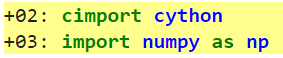

  Necessariamente temos que interagir para importar as bibliotecas python e suas funções que iremos utilizar
* **Criação de função**

  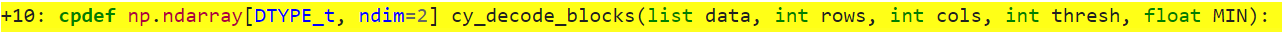

  * Nós declaramos que a função irá retornar um `np.ndarray[DTYPE_t, ndim=2]`, isto é um numpy array com 2 dimensões contendo dados do tipo `DTYPE_t`, esta variável definimos logo acima: `ctypedef np.float32_t DTYPE_t`, que nada mais é que números do tipo float32, o `_t` é uma sintaxe específica para indicar o tipo float32 do numpy "compilado" para cython, precisamos chamar `ctypedef` para definir variáveis "compiladas".
  * Na assinatura da função declaramos todos os tipos dos argumentos, os tipos são os próprios do python, que serão transformados em tipos C ao serem compilados.
  * Definimos a função com a chamada `cpdef`, com essa chamada não só compilamos nossa função como ela também fica disponível para importação como objeto python. Caso quiséssemos somente compilar uma função ou objeto e não importá-lo como objeto python, utilizamos `cdef`

  _Recebemos objetos python na função, então necessariamente há interação porque esses objetos são externos ao nosso código que será compilado_

* **Declaração do array que será preenchido e retornado**
 
 image.png

  Aqui utilizamos nossos objetos python: `rows, cols, thresh` e criamos um numpy array, aqui invariavelmente também há interação com objetos python

* **Acesso aos bytes de espectro**

 image.png

  Mesmo caso anterior, estamos acessando os bytes armazenados no objeto `data` 

* **Retorno do array**

 image.png

 Aqui temos uma interação leve ( amarelo mais claro ) porque temos que retornar o array que foi preenchido pelo nosso código em C de volta para um numpy array em python

 Todos as demais variáveis dentro da função, além dos loops, é compilado para um código em C sem qualquer interação com o python e por isso é muito rápido. Conseguimos essa façanha bastando basicamente declarar os tipos de todas as variáveis e assim o cython faz sua mágica.

 Vamos ver como desempenhamos: 


In [ ]:
%%time
# dados fixos
offset = compressed_blocks[0].offset
MIN = offset - 127.5
cols = compressed_blocks[0].ndata
thresh = compressed_blocks[0].thresh
rows = len(compressed_blocks)
data_blocks = [b.data[b.start:b.stop] for b in compressed_blocks] # colocar os dados de espectro diretamente numa lista
d = cy_decode_blocks(data_blocks, rows, cols, thresh, MIN)

CPU times: user 2.04 s, sys: 1.82 s, total: 3.86 s
Wall time: 3.85 s


Menos de 4s para processar quase 2 bilhões de pontos flutantes! 🤯

E agora nossos blocos em si são classes Python com diversos atributos, sendo um deles, `.data` nossos dados de espectro em bytes, assim primeiramente extraimos os bytes e não utilizamos diretamente a classe Python. O motivo disso é que para usarmos a eficiência do compilador em C nossas estruturas de dados precisam ser as mais simples possíveis, de preferência tipos nativos, assim o código em C não precisa intercambiar com o python tornando-o lento.  

In [ ]:
print(d[5000])

[ -96.5  -96.5  -95.5 ... -100.  -100.  -100. ]

In [ ]:
print(d.shape)

(133932, 14848)

Um detalhe é que não utilizamos `np.float16` como nas implementações anteriores porque não existe `float16` nativamente em C, assim não poderíamos declarar um tipo de array "compilado" em C e a cada leitura e escrita do array teríamos que interagir com o objeto python, tornando a execução muito mais lenta.

Espero ter atiçado um pouco mais a sua curiosidade sobre o Cython caso ainda não o conheça, e mostrado que não é um bicho de sete cabeças e é possível ter eficiência de C ( ou quase ) no seu código python modificando muito pouco. Esse foi mais um exercício exploratório motivado pela curiosidade de quanto eu conseguiria otimizar a leitura de uma estrutura de dados que era importante pra mim, por ter dedicado muitas horas nela por conta do meu trabalho, fiquei feliz pelos resultados e acabei aprendendo muita coisa por conta dele. 

Caso você tenha milagrosamente chegado até esse ponto o meu bônus pra você é que você pode ignorar tudo isso porque já fizeram de maneira infinitamente melhor pra você: A biblioteca [Numba](https://numba.pydata.org/numba-doc/latest/user/5minguide.html) é um compilador just-in-time para Python que funciona melhor em código que usa matrizes e funções NumPy e loops. Ele não só compila como paraleliza seu código em todos os cores da CPU ou da GPU caso você tiver.